In [1]:
# Import primary libraries
import py4DSTEM
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import os

# Verify libraries
print("All libraries imported successfully!")

print(f"py4DSTEM version: {py4DSTEM.__version__}")
print(f"HyperSpy version: {hs.__version__}")

All libraries imported successfully!
py4DSTEM version: 0.14.16
HyperSpy version: 2.3.0


# Task 1. Virtual Detector Framework

### A. Define detector geometries

In [2]:
# Generate masks in reciprocal space (kx, ky grid)
def make_reciprocal_grid(dp_shape, center=None):

    ny, nx = dp_shape

    if center is None:
        cx = (nx - 1) / 2
        cy = (ny - 1) / 2
    else:
        cx, cy = center

    Y, X = np.indices((ny, nx))  # Y first (rows), X second (cols)
    X = X.astype(np.float64) - cx
    Y = Y.astype(np.float64) - cy
    R = np.sqrt(X**2 + Y**2)

    return X, Y, R

In [3]:
# Define Bright Field (BF) detector
def bright_field_detector(dp_shape, radius_px, center=None):
   
    if radius_px <= 0:
        raise ValueError("BF radius must be > 0")

    X, Y, R = make_reciprocal_grid(dp_shape, center=center)
    return (R <= radius_px).astype(np.float32)

In [4]:
# Define Annular Dark Field (ADF) detector
def annular_dark_field_detector(dp_shape, r_inner_px, r_outer_px, center=None):

    if r_inner_px < 0 or r_outer_px <= 0:
        raise ValueError("ADF radii must be >= 0 and outer > 0")
    if r_inner_px >= r_outer_px:
        raise ValueError("r_inner_px must be < r_outer_px")

    X, Y, R = make_reciprocal_grid(dp_shape, center=center)
    return ((R >= r_inner_px) & (R <= r_outer_px)).astype(np.float32)

In [5]:
# Define Custom detector
def custom_detector(mask):
    
    return np.asarray(mask, dtype=np.float32)

### B. Apply detectors to 4D-STEM data

In [6]:
# Apply chosen virtual detector to datset
def apply_virtual_detector(data4d, detector_mask):
  
    data4d = np.asarray(data4d)
    detector_mask = np.asarray(detector_mask)

    if data4d.ndim != 4:
        raise ValueError(f"apply_virtual_detector expected 4D data, got shape {data4d.shape}")

    sx, sy, ny, nx = data4d.shape

    if detector_mask.shape != (ny, nx):
        raise ValueError(
            f"Detector mask shape {detector_mask.shape} does not match DP shape {(ny, nx)}"
        )

    virtual_image = np.zeros((sx, sy), dtype=np.float64)

    # faster + safer: dot product on flattened arrays
    m = detector_mask.astype(np.float64).ravel()

    for i in range(sx):
        for j in range(sy):
            dp = data4d[i, j].astype(np.float64).ravel()
            virtual_image[i, j] = np.dot(dp, m)

    return virtual_image

### C. Safety Checks

In [7]:
# Validation proper mask application
def validate_detector_geometry(dp_shape, center, r_outer_px=None):
   
    ny, nx = dp_shape
    cx, cy = center

    if not (0 <= cx < nx and 0 <= cy < ny):
        raise ValueError(f"Detector center {(cx, cy)} is outside DP bounds {(ny, nx)}")

    # Max possible radius before leaving array: distance to farthest corner
    corners = np.array([[0, 0], [0, ny-1], [nx-1, 0], [nx-1, ny-1]], dtype=np.float64)
    dists = np.sqrt((corners[:,0] - cx)**2 + (corners[:,1] - cy)**2)
    r_max = dists.max()

    if r_outer_px is not None and r_outer_px > r_max:
        raise ValueError(
            f"Detector outer radius {r_outer_px:.2f}px exceeds max allowable {r_max:.2f}px for center {(cx, cy)}"
        )

    return True


def validate_detector_mask(mask, dp_shape):
   
    if mask.shape != dp_shape:
        raise ValueError(f"Mask shape {mask.shape} does not match DP shape {dp_shape}")
    if np.sum(mask) == 0:
        raise ValueError("Detector mask is empty")
    return True

### D. Demo & validation with Si-Au

#### Load, inspect, and extract data

In [8]:
# Load 4D-STEM data
filepath = "Diffraction Si_Au_Calib.dm4"
dc = py4DSTEM.io.import_file(filepath)

print("Calibration dataset successfully loaded!")

Calibration dataset successfully loaded!


In [9]:
# Inspect 4D-STEM data upon import
print(type(dc))
print("Dataset shape:", dc.data.shape)
print(dc.calibration)

<class 'py4DSTEM.datacube.datacube.DataCube'>
Dataset shape: (20, 20, 256, 256)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.026740015
             R_pixel_size:    0.0020393706
             Q_pixel_units:   A^-1
             R_pixel_units:   µm
             QR_flip:         False
)


In [10]:
# Extract raw 4D array
data4d = dc.data

# Confirm dimensions
sx, sy, ny, nx = data4d.shape
print("Scan shape:", (sx, sy))
print("Diffraction pattern shape:", (nx, ny))

Scan shape: (20, 20)
Diffraction pattern shape: (256, 256)


#### Verification of functionality

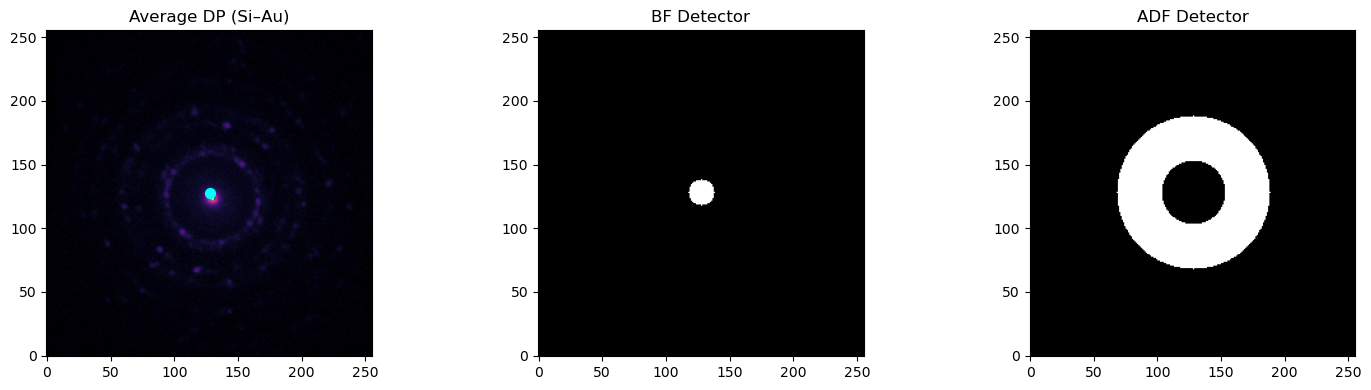

In [11]:
# Build average diffraction pattern
avg_dp = np.mean(data4d, axis=(0,1))

# Use geometric center for Task 1 demo
beam_center = (avg_dp.shape[1]//2, avg_dp.shape[0]//2)
dp_shape = avg_dp.shape

# Build detectors
bf_mask = bright_field_detector(dp_shape, radius_px=10, center=beam_center)
adf_mask = annular_dark_field_detector(dp_shape, r_inner_px=25, r_outer_px=60, center=beam_center)

# Validate geometry
validate_detector_geometry(dp_shape, center=beam_center, r_outer_px=60)
validate_detector_mask(bf_mask, dp_shape)
validate_detector_mask(adf_mask, dp_shape)

# Apply detectors
bf_image = apply_virtual_detector(data4d, bf_mask)
adf_image = apply_virtual_detector(data4d, adf_mask)

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.imshow(np.sqrt(avg_dp), cmap="magma", origin="lower")
plt.scatter(beam_center[0], beam_center[1], c='cyan', s=50)
plt.title("Average DP (Si–Au)")

plt.subplot(1,3,2)
plt.imshow(bf_mask, cmap="gray", origin="lower")
plt.title("BF Detector")

plt.subplot(1,3,3)
plt.imshow(adf_mask, cmap="gray", origin="lower")
plt.title("ADF Detector")

plt.tight_layout()
plt.show()

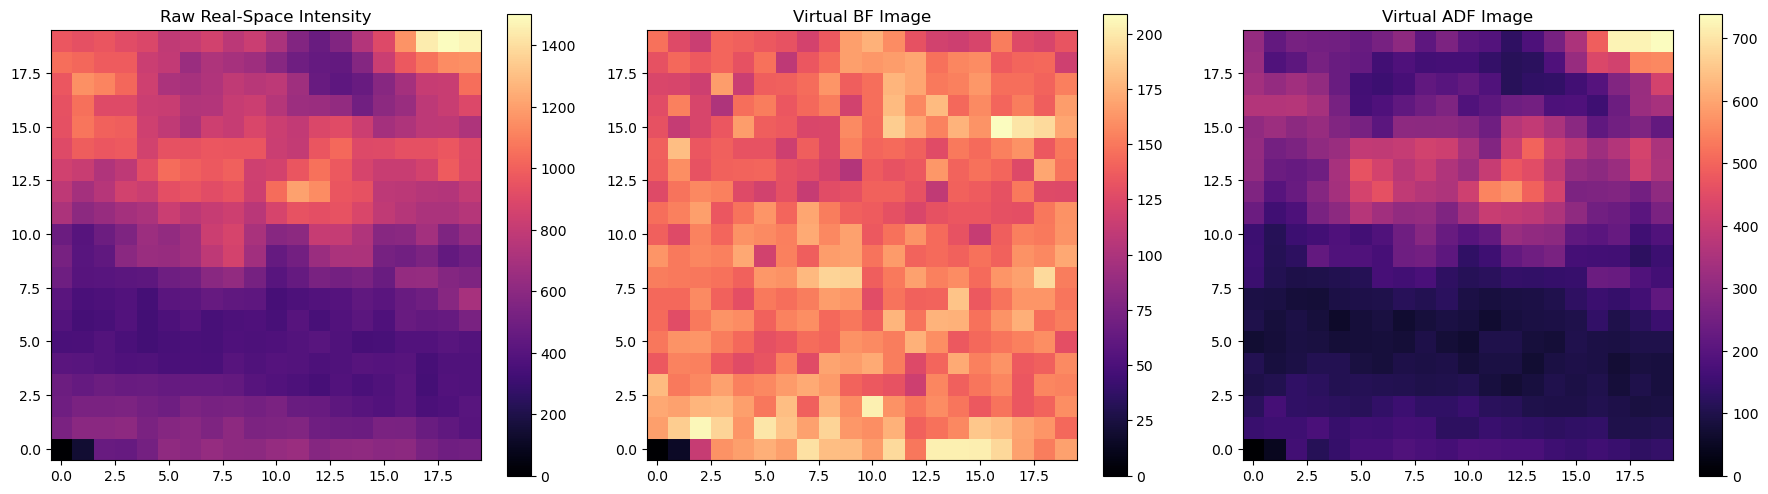

In [12]:
real_space_img = np.sum(data4d, axis=(2,3))

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.imshow(real_space_img, cmap="magma", origin="lower")
plt.title("Raw Real-Space Intensity")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(bf_image, cmap="magma", origin="lower")
plt.title("Virtual BF Image")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(adf_image, cmap="magma", origin="lower")
plt.title("Virtual ADF Image")
plt.colorbar()

plt.tight_layout()
plt.show()

# Task 2. Diffraction Analysis Functions

#### A. Define additional functions and metrics

In [13]:
# Compute total intensity
def total_scattered_intensity(dp):
    
    return float(np.sum(dp))

In [14]:
# Compute Center of Mass (CoM)
def center_of_mass(dp):
   
    dp = np.asarray(dp, dtype=np.float64)
    total = np.sum(dp)

    if total <= 0 or not np.isfinite(total):
        return np.nan, np.nan

    ny, nx = dp.shape
    Y, X = np.indices((ny, nx))  # Y rows, X cols

    cx = np.sum(X * dp) / total
    cy = np.sum(Y * dp) / total

    return cx, cy

In [15]:
# Compute beam center from average diffraction pattern
def estimate_beam_center_com(avg_dp):

    cx, cy = center_of_mass(avg_dp)
    if not np.isfinite(cx) or not np.isfinite(cy):
        raise ValueError("Beam center undefined (avg_dp sum is zero or invalid).")
    return int(round(cx)), int(round(cy))

In [16]:
# Compute intensity and CoM maps over scan
def compute_intensity_and_com(data4d):
   
    sx, sy, ny, nx = data4d.shape

    intensity_map = np.zeros((sx, sy), dtype=np.float64)
    com_x = np.full((sx, sy), np.nan, dtype=np.float64)
    com_y = np.full((sx, sy), np.nan, dtype=np.float64)

    for i in range(sx):
        for j in range(sy):
            dp = data4d[i, j]
            intensity_map[i, j] = total_scattered_intensity(dp)
            cx, cy = center_of_mass(dp)
            com_x[i, j] = cx
            com_y[i, j] = cy

    return intensity_map, com_x, com_y


### B. Radial intensity profile

In [17]:
# Radial intensity profile
def radial_intensity_profile(dp, R, bin_width_px=1.0):

    dp = np.asarray(dp, dtype=np.float64)

    r = R.ravel()
    I = dp.ravel()

    r_max = np.max(r)
    bins = np.arange(0, r_max + bin_width_px, bin_width_px)

    # Bin index for each pixel
    idx = np.digitize(r, bins) - 1
    n_bins = len(bins) - 1

    radial_sum = np.zeros(n_bins, dtype=np.float64)
    counts = np.zeros(n_bins, dtype=np.float64)

    # Accumulate
    for k in range(n_bins):
        mask = (idx == k)
        radial_sum[k] = np.sum(I[mask])
        counts[k] = np.sum(mask)

    I_r = radial_sum / np.maximum(counts, 1.0)
    r_centers = 0.5 * (bins[:-1] + bins[1:])

    return r_centers, I_r

In [18]:
# Reciprocal space calibration helper
def get_reciprocal_calibration(dc=None, manual=None):

    # Try datacube
    if dc is not None:
        if hasattr(dc, "Q_pixel_size") and hasattr(dc, "Q_pixel_units"):
            q = getattr(dc, "Q_pixel_size")
            u = getattr(dc, "Q_pixel_units")
            if q is not None and u is not None:
                return float(q), str(u)

    # Manual fallback
    if manual is not None:
        q = manual.get("q_pixel_size", None)
        u = manual.get("q_pixel_units", None)
        if q is not None and u is not None:
            return float(q), str(u)

    # Final fallback
    return 1.0, "pixels"

def pixels_to_reciprocal(r_px, q_pixel_size):
    
    return np.asarray(r_px, dtype=np.float64) * float(q_pixel_size)

#### C. Demo & validation with Si-Au

Beam center (CoM): (130, 125)


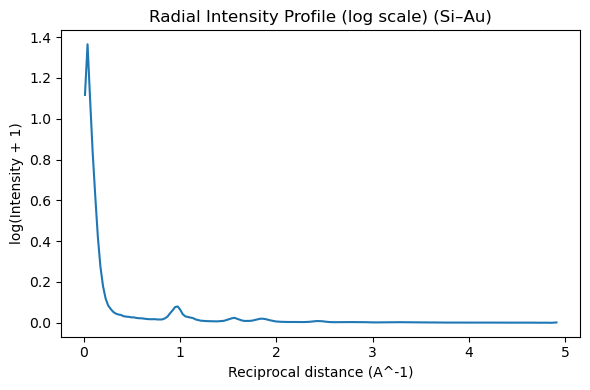

In [19]:
avg_dp = np.mean(data4d, axis=(0,1))

beam_cx, beam_cy = estimate_beam_center_com(avg_dp)
print("Beam center (CoM):", (beam_cx, beam_cy))

# Build R grid using Task 1 helper
X, Y, R = make_reciprocal_grid(avg_dp.shape, center=(beam_cx, beam_cy))

r_px, I_r = radial_intensity_profile(avg_dp, R, bin_width_px=1.0)

q_pixel_size, q_units = get_reciprocal_calibration(dc=dc)
r_q = pixels_to_reciprocal(r_px, q_pixel_size)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(r_q, np.log(I_r + 1))
plt.xlabel(f"Reciprocal distance ({q_units})")
plt.ylabel("log(Intensity + 1)")
plt.title("Radial Intensity Profile (log scale) (Si–Au)")
plt.tight_layout()
plt.show()

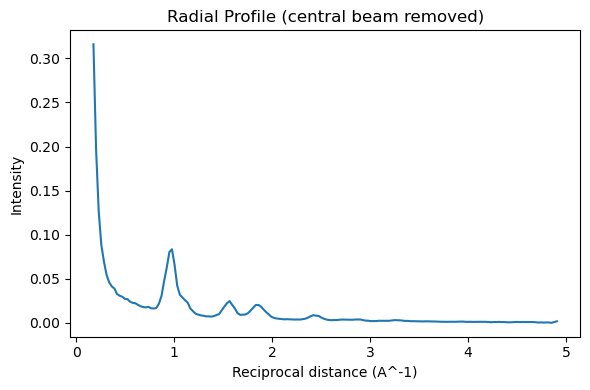

In [20]:
# Enhanced visualization (manual adjustment)
mask = r_px > 6
plt.figure(figsize=(6,4))
plt.plot(r_q[mask], I_r[mask])
plt.xlabel(f"Reciprocal distance ({q_units})")
plt.ylabel("Intensity")
plt.title("Radial Profile (central beam removed)")
plt.tight_layout()
plt.show()

# Task 3. The Analysis Pipeline

### A. Incorporate additional calibration and normalization

In [21]:
# Normalize axes (to handle permuted axes)
def normalize_datacube_axes(data4d):

    shape = data4d.shape
    if len(shape) != 4:
        raise ValueError(f"Expected 4D array, got shape {shape}")

    # Identify diffraction axes as the two largest dims
    sorted_dims = sorted(enumerate(shape), key=lambda x: x[1], reverse=True)
    diff_axes = [sorted_dims[0][0], sorted_dims[1][0]]
    scan_axes = [i for i in range(4) if i not in diff_axes]

    axis_order = scan_axes + diff_axes
    data4d_norm = np.transpose(data4d, axis_order)

    return data4d_norm, axis_order

In [22]:
# Calibration & metadata extraction
def extract_calibration_and_metadata(dc=None, manual=None, verbose=True):

    meta = {
        "q_pixel_size": None,
        "q_pixel_units": None,
        "scan_step_nm": None,
        "warnings": [],
        "source": "none"
    }

    # --- Preferred: py4DSTEM DataCube calibration attributes (Si–Au) ---
    if dc is not None:
        try:
            if verbose and hasattr(dc, "calibration"):
                print("dc.calibration:", dc.calibration)

            # Reciprocal-space calibration
            if hasattr(dc, "Q_pixel_size"):
                meta["q_pixel_size"] = dc.Q_pixel_size
            if hasattr(dc, "Q_pixel_units"):
                meta["q_pixel_units"] = dc.Q_pixel_units

            # Real-space calibration (scan step)
            if hasattr(dc, "calibration"):
                cal = dc.calibration
                if hasattr(cal, "R_pixel_size") and hasattr(cal, "R_pixel_units"):
                    if cal.R_pixel_units == "µm":
                        meta["scan_step_nm"] = float(cal.R_pixel_size) * 1000.0
                    elif cal.R_pixel_units == "nm":
                        meta["scan_step_nm"] = float(cal.R_pixel_size)
                    else:
                        meta["warnings"].append(f"Unrecognized R_pixel_units '{cal.R_pixel_units}'")

            if meta["q_pixel_size"] is not None and meta["q_pixel_units"] is not None:
                meta["source"] = "dc.Q_pixel_size/Q_pixel_units"

        except Exception as e:
            meta["warnings"].append(f"Could not read dc calibration: {repr(e)}")

    # --- Manual fallback (Si/SiGe) ---
    if manual is not None:
        if meta["q_pixel_size"] is None:
            meta["q_pixel_size"] = manual.get("q_pixel_size", None)
        if meta["q_pixel_units"] is None:
            meta["q_pixel_units"] = manual.get("q_pixel_units", None)
        if meta["scan_step_nm"] is None:
            meta["scan_step_nm"] = manual.get("scan_step_nm", None)

        if meta["source"] == "none" and (
            meta["q_pixel_size"] is not None or meta["scan_step_nm"] is not None
        ):
            meta["source"] = "manual"

    # --- Final fallback ---
    if meta["q_pixel_size"] is None or meta["q_pixel_units"] is None:
        meta["q_pixel_size"] = 1.0
        meta["q_pixel_units"] = "pixels"
        meta["warnings"].append("Reciprocal calibration missing → using pixels.")

    if meta["scan_step_nm"] is None:
        meta["warnings"].append("Scan step size missing → scale bars require manual scan_step_nm.")

    if verbose:
        print(f"Calibration: {meta['q_pixel_size']} {meta['q_pixel_units']} (source: {meta['source']})")
        if meta["scan_step_nm"] is not None:
            print(f"Scan step: {meta['scan_step_nm']:.3f} nm/pixel")
        if meta["warnings"]:
            print("Warnings:", *meta["warnings"], sep="\n  - ")

    return meta

In [23]:
from scipy.ndimage import shift as ndi_shift

def apply_global_com_correction_to_center(data4d_norm, beam_center_px):
   
    sx, sy, ny, nx = data4d_norm.shape

    # Target = geometric center of difraction plane
    target_cx = (nx - 1) / 2
    target_cy = (ny - 1) / 2

    cx, cy = beam_center_px
    dx = target_cx - cx
    dy = target_cy - cy

    corrected = np.empty_like(data4d_norm, dtype=np.float64)

    for i in range(sx):
        for j in range(sy):
            dp = data4d_norm[i, j].astype(np.float64)
            # ndi_shift expects (y_shift, x_shift)
            corrected[i, j] = ndi_shift(dp, shift=(dy, dx), order=1, mode="nearest")

    return corrected, (dx, dy), (target_cx, target_cy)

### C. Combine defined functions into single pipeline

In [24]:
def run_pipeline(
    data4d,
    detectors,                 # dict of detector masks OR dict of callables
    dc=None,
    manual_calibration=None,
    compute_radial=True,
    radial_bin_width_px=1.0,
    verbose=True
):

    results = {}

    # 1) Normalize axis order
    data4d_norm, axis_order = normalize_datacube_axes(data4d)
    sx, sy, ny, nx = data4d_norm.shape

    results["axis_order"] = axis_order
    results["shape_norm"] = data4d_norm.shape

    if verbose:
        print("Axis order used:", axis_order)
        print("Normalized shape:", data4d_norm.shape)

    # 2) Calibration/metadata extraction
    meta = extract_calibration_and_metadata(dc=dc, manual=manual_calibration, verbose=verbose)
    results["metadata"] = meta

    # 3) Average DP + beam center
    avg_dp_before = np.mean(data4d_norm, axis=(0, 1))
    beam_cx_before, beam_cy_before = estimate_beam_center_com(avg_dp_before)

    # 3.5) ALWAYS apply global CoM correction to center
    data4d_norm, (dx, dy), target_center = apply_global_com_correction_to_center(
    data4d_norm, beam_center_px=(beam_cx_before, beam_cy_before)
    )

    # Recompute avg DP + beam center (AFTER correction) for sanity
    avg_dp_after = np.mean(data4d_norm, axis=(0, 1))
    beam_cx_after, beam_cy_after = estimate_beam_center_com(avg_dp_after)

    results["com_correction"] = {
        "applied": True,
        "beam_center_before": (beam_cx_before, beam_cy_before),
        "target_center": target_center,
        "dx": dx,
        "dy": dy,
        "beam_center_after": (beam_cx_after, beam_cy_after),
    }

    results["beam_center"] = (beam_cx_after, beam_cy_after)

    if verbose:
        print(f"Beam center before: {(beam_cx_before, beam_cy_before)}")
        print(f"Applied global shift: dx={dx:.2f}, dy={dy:.2f} → target={target_center}")
        print(f"Beam center after:  {(beam_cx_after, beam_cy_after)}")

    # 4) Apply all detectors
    virtual_images = {}
    for name, mask in detectors.items():
        validate_detector_mask(mask, (ny, nx))
        virtual_images[name] = apply_virtual_detector(data4d_norm, mask)

    results["virtual_images"] = virtual_images

    # 5) Diffraction statistics (intensity + CoM maps)
    intensity_map, com_x, com_y = compute_intensity_and_com(data4d_norm)
    results["metrics"] = {
        "total_intensity": intensity_map,
        "com_x": com_x,
        "com_y": com_y
    }

    # 6) Radial profile (optional; uses calibration)
    if compute_radial:
        X, Y, R = make_reciprocal_grid(avg_dp.shape, center=(beam_cx, beam_cy))
        r_px, I_r = radial_intensity_profile(avg_dp, R, bin_width_px=radial_bin_width_px)

        # Convert pixels → calibrated units
        r_q = r_px * meta["q_pixel_size"]

        results["radial_profile"] = {
            "r_px": r_px,
            "r_q": r_q,
            "I_r": I_r,
            "unit": meta["q_pixel_units"],
            "central_beam_mask_px": 6  # your preference (used in plotting later)
        }

    return results

#### D. Adding Figure Automation Helpers

In [25]:
# Add scale bar helper
def add_scale_bar_nm(ax, scan_step_nm, length_nm=None, location="lower left",
                     color="white", linewidth=4, pad_frac=0.06, text_offset_frac=0.05):
    
    arr = ax.images[0].get_array()
    ny, nx = arr.shape

    width_nm = nx * scan_step_nm

    if length_nm is None:
        # pick a reasonable length ~25% of image width
        candidates = np.array([10, 20, 50, 100, 200, 500], dtype=float)
        target = 0.25 * width_nm
        length_nm = float(candidates[np.argmin(np.abs(candidates - target))])

    length_px = length_nm / scan_step_nm

    if location == "lower left":
        x0 = pad_frac * nx
        y0 = (1 - pad_frac) * ny
    elif location == "lower right":
        x0 = (1 - pad_frac) * nx - length_px
        y0 = (1 - pad_frac) * ny
    else:
        x0 = pad_frac * nx
        y0 = (1 - pad_frac) * ny

    ax.plot([x0, x0 + length_px], [y0, y0],
            color=color, linewidth=linewidth, solid_capstyle="butt")

    ax.text(x0, y0 - text_offset_frac * ny,
            f"{int(round(length_nm))} nm",
            color=color, fontsize=10, ha="left", va="top")

In [26]:
# Automatically produce and save virtual images with standard settings
def save_virtual_images_png(results, dataset_name, out_dir="figures",
                            cmap="magma", include_real_space=True, dpi=300):
    
    os.makedirs(out_dir, exist_ok=True)

    scan_step_nm = results["metadata"].get("scan_step_nm", None)

    # Real-space intensity reference (total intensity map)
    if include_real_space:
        real_img = results["metrics"]["total_intensity"]
        plt.figure(figsize=(6,6))
        ax = plt.gca()
        im = ax.imshow(real_img, cmap=cmap, origin="lower")
        ax.set_title(f"{dataset_name}: Raw Real-Space Intensity (Total DP Sum)", pad=20)
    
        ny, nx = real_img.shape

        if scan_step_nm is not None:
            x_ticks = np.linspace(0, nx-1, 5)
            y_ticks = np.linspace(0, ny-1, 5)

            ax.set_xticks(x_ticks)
            ax.set_yticks(y_ticks)

            ax.set_xticklabels([f"{(x*scan_step_nm):.0f}" for x in x_ticks])
            ax.set_yticklabels([f"{(y*scan_step_nm):.0f}" for y in y_ticks])

            ax.set_xlabel("x (nm)")
            ax.set_ylabel("y (nm)")
        else:
            ax.set_xlabel("x (pixels)")
            ax.set_ylabel("y (pixels)")

        plt.colorbar(im, fraction=0.046, pad=0.04)

        if scan_step_nm is not None:
            add_scale_bar_nm(ax, scan_step_nm, location="lower left", color="white")
        else:
            print("WARNING: scan_step_nm missing → scale bar not added.")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(os.path.join(out_dir, f"{dataset_name}_real_space_intensity.png"), dpi=dpi, bbox_inches="tight")
        plt.show()

    # Virtual images (BF/ADF/etc.)
    for det_name, img in results["virtual_images"].items():
        plt.figure(figsize=(6,6))
        ax = plt.gca()
        im = ax.imshow(img, cmap=cmap, origin="lower")
        ax.set_title(f"{dataset_name}: Virtual {det_name} Image", pad=20)
        
        ny, nx = img.shape

        if scan_step_nm is not None:
            x_ticks = np.linspace(0, nx-1, 5)
            y_ticks = np.linspace(0, ny-1, 5)

            ax.set_xticks(x_ticks)
            ax.set_yticks(y_ticks)

            ax.set_xticklabels([f"{(x*scan_step_nm):.0f}" for x in x_ticks])
            ax.set_yticklabels([f"{(y*scan_step_nm):.0f}" for y in y_ticks])

            ax.set_xlabel("x (nm)")
            ax.set_ylabel("y (nm)")
        else:
            ax.set_xlabel("x (pixels)")
            ax.set_ylabel("y (pixels)")

        plt.colorbar(im, fraction=0.046, pad=0.04)

        if scan_step_nm is not None:
            add_scale_bar_nm(ax, scan_step_nm, location="lower left", color="white")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(os.path.join(out_dir, f"{dataset_name}_virtual_{det_name}.png"), dpi=dpi, bbox_inches="tight")
        plt.show()

In [27]:
# Standard settings for  radial profile
def save_radial_profile_png(results, dataset_name, out_dir="assignment_02_output",
                            central_beam_mask_px=6, dpi=300):
    
    os.makedirs(out_dir, exist_ok=True)

    if "radial_profile" not in results:
        print("No radial_profile found in results (compute_radial=False).")
        return

    rp = results["radial_profile"]
    r_px = rp["r_px"]
    r_q = rp["r_q"]
    I_r = rp["I_r"]
    unit = rp["unit"]

    mask = r_px > central_beam_mask_px

    plt.figure(figsize=(6,4))
    plt.plot(r_q[mask], I_r[mask])
    plt.xlabel(f"Reciprocal distance ({unit})")
    plt.ylabel("Intensity")
    plt.title(f"{dataset_name}: Radial Intensity Profile (central beam removed)")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{dataset_name}_radial_profile.png"), dpi=dpi)
    plt.show()

#### E. Demo & validation with Si-Au

In [28]:
# Ensure data4d + avg_dp exist upstream or compute here
data4d = dc.data

avg_dp = np.mean(data4d, axis=(0,1))
beam_center = (avg_dp.shape[1]//2, avg_dp.shape[0]//2)  # Task 3 demo can use geometric center

dp_shape = avg_dp.shape
bf_mask = bright_field_detector(dp_shape, radius_px=10, center=beam_center)
adf_mask = annular_dark_field_detector(dp_shape, r_inner_px=25, r_outer_px=60, center=beam_center)

detectors = {"BF": bf_mask, "ADF": adf_mask}

results = run_pipeline(
    data4d=data4d,
    detectors=detectors,
    dc=dc,
    manual_calibration=None,
    compute_radial=True,
    verbose=True
)

Axis order used: [0, 1, 2, 3]
Normalized shape: (20, 20, 256, 256)
dc.calibration: Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.026740015
             R_pixel_size:    0.0020393706
             Q_pixel_units:   A^-1
             R_pixel_units:   µm
             QR_flip:         False
)
Calibration: 0.02674001455307007 A^-1 (source: dc.Q_pixel_size/Q_pixel_units)
Scan step: 2.039 nm/pixel
Beam center before: (130, 125)
Applied global shift: dx=-2.50, dy=2.50 → target=(127.5, 127.5)
Beam center after:  (128, 127)


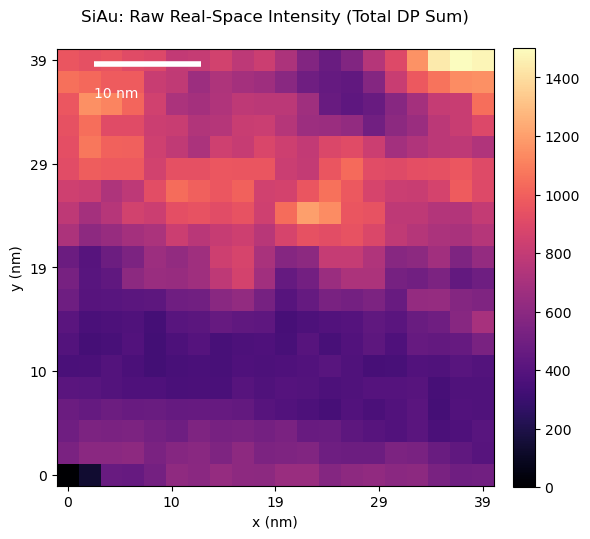

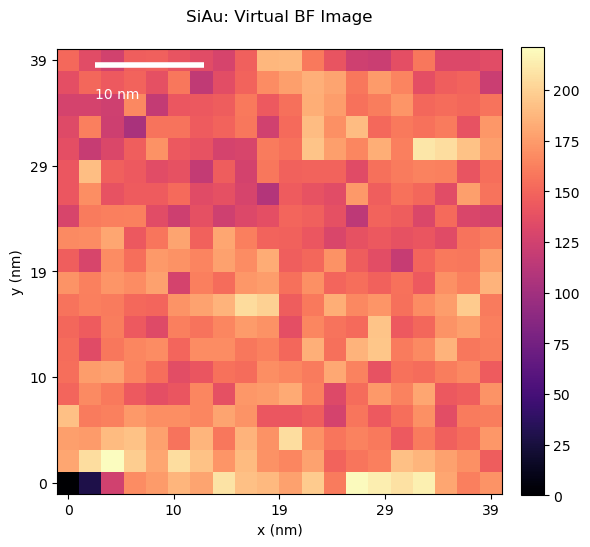

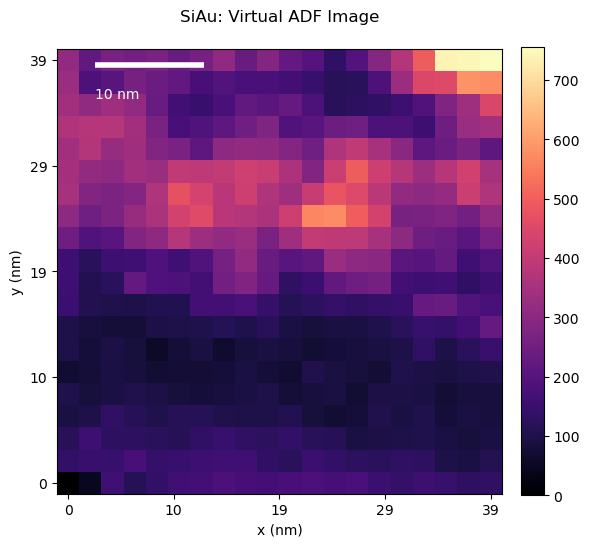

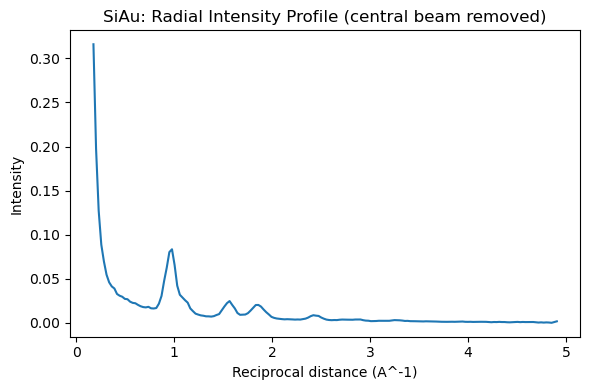

In [29]:
save_virtual_images_png(results, dataset_name="SiAu", out_dir="assignment_02_output")
save_radial_profile_png(results, dataset_name="SiAu", out_dir="assignment_02_output", central_beam_mask_px=6)

# Task 4. Apply Pipeline

#### A. Apply to Si-SiGe Dataset

In [30]:
# Load 4D-STEM data
import py4DSTEM

filepath_sige = "Si-SiGe.dm4"
dc_sige = py4DSTEM.io.import_file(filepath_sige)

print("Dataset successfully loaded!")

Dataset successfully loaded!


In [31]:
# Inspect 4D-STEM data upon import
print(type(dc_sige))
print("Dataset shape:", dc_sige.data.shape)
print(dc_sige.calibration)

<class 'py4DSTEM.datacube.datacube.DataCube'>
Dataset shape: (480, 448, 77, 17)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             QR_flip:         False
)


In [33]:
# Inspect alternative dataset load
import hyperspy.api as hs

# Load dataset as HyperSpy signal
signal_sige = hs.load("Si-SiGe.dm4")

# Inspect navigation and signal axes of dataset
print(signal_sige.axes_manager)

<Axes manager, axes: (448, 480|17, 77)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               z |    448 |      0 |       0 |   0.062 |   1/nm 
     <undefined> |    480 |      0 |       0 |   0.062 |   1/nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |     17 |      0 |       0 |       2 |     nm 
               y |     77 |      0 |       0 |       2 |     nm 


In [34]:
# Manual calibration
manual_cal = {
    "q_pixel_size": 0.062,
    "q_pixel_units": "1/nm",
    "scan_step_nm": 2 # nm per scan pixel
}

In [35]:
# Correct permuted axes
dc_sige.data = np.transpose(dc_sige.data, (2, 3, 0, 1))

# Verify corrected axes
print("Dataset shape:", dc_sige.data.shape)

Dataset shape: (77, 17, 480, 448)


In [36]:
# Define detectors
data4d_sige = dc_sige.data

avg_dp_sige = np.mean(data4d_sige, axis=(0,1))
beam_center_sige = (avg_dp_sige.shape[1]//2, avg_dp_sige.shape[0]//2)

dp_shape_sige = avg_dp_sige.shape

bf_mask_sige = bright_field_detector(dp_shape_sige, radius_px=10, center=beam_center_sige)
adf_mask_sige = annular_dark_field_detector(dp_shape_sige, r_inner_px=25, r_outer_px=60, center=beam_center_sige)

detectors_sige = {
    "BF": bf_mask_sige,
    "ADF": adf_mask_sige
}

Axis order used: [0, 1, 2, 3]
Normalized shape: (77, 17, 480, 448)
Calibration: 0.062 1/nm (source: manual)
Scan step: 2.000 nm/pixel
Beam center before: (224, 240)
Applied global shift: dx=-0.50, dy=-0.50 → target=(223.5, 239.5)
Beam center after:  (224, 240)


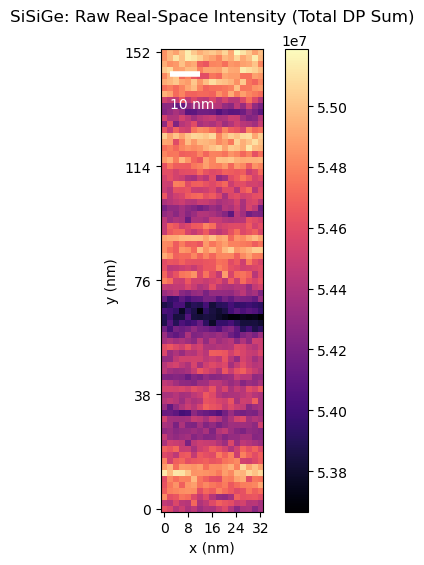

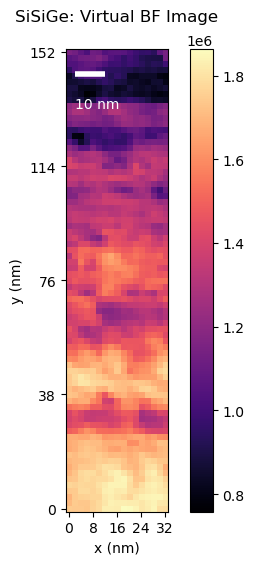

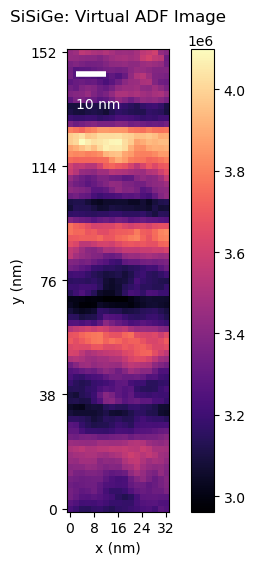

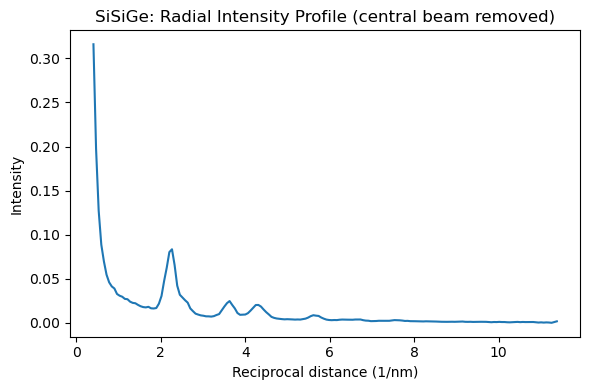

Pipeline complete! Review generated metrics and figures.


In [37]:
# Run pipeline & save figures
results_sige = run_pipeline(
    data4d=data4d_sige,
    detectors=detectors_sige,
    dc=None,
    manual_calibration=manual_cal,
    compute_radial=True
)

save_virtual_images_png(results_sige, dataset_name="SiSiGe", out_dir="assignment_02_output")
save_radial_profile_png(results_sige, dataset_name="SiSiGe", out_dir="assignment_02_output")

print("Pipeline complete! Review generated metrics and figures.")

#### B. Interface (Interactive) Analysis

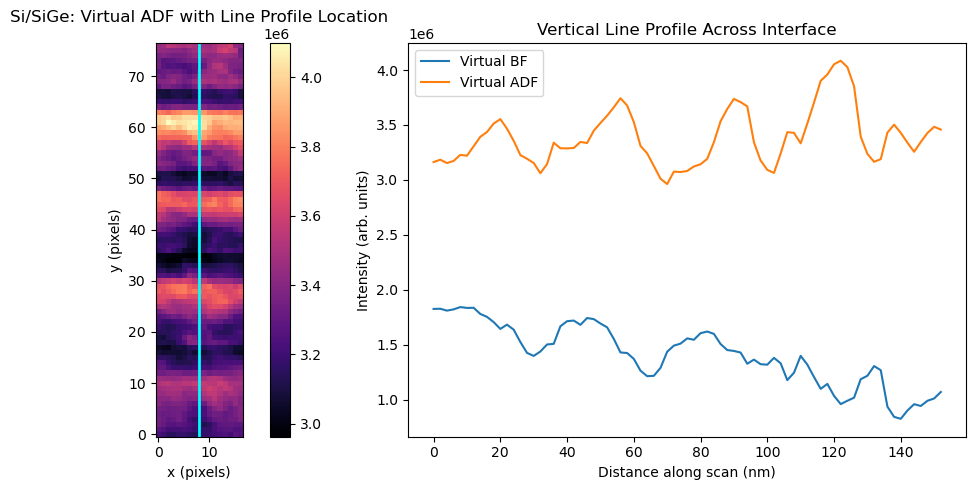

In [38]:
# Static interface analysis
bf_img = results_sige["virtual_images"]["BF"]
adf_img = results_sige["virtual_images"]["ADF"]
scan_step_nm = results_sige["metadata"]["scan_step_nm"]

ny, nx = bf_img.shape

# Choose x-position that crosses the interface (adjust after visual inspection)
x0 = nx // 2

# Extract vertical profiles
bf_profile = bf_img[:, x0]
adf_profile = adf_img[:, x0]

y_nm = np.arange(ny) * scan_step_nm

plt.figure(figsize=(12,5))

# --- Left: Image with line ---
plt.subplot(1,2,1)
plt.imshow(adf_img, cmap="magma", origin="lower")
plt.axvline(x0, color="cyan", linewidth=2)
plt.title("Si/SiGe: Virtual ADF with Line Profile Location", pad = 15)
plt.colorbar()
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")

# --- Right: Profiles ---
plt.subplot(1,2,2)
plt.plot(y_nm, bf_profile, label="Virtual BF")
plt.plot(y_nm, adf_profile, label="Virtual ADF")
plt.xlabel("Distance along scan (nm)")
plt.ylabel("Intensity (arb. units)")
plt.title("Vertical Line Profile Across Interface")
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Interactive interface analysis

import ipywidgets as widgets
from IPython.display import display

def interactive_vertical_profile(x0):
    bf_profile = bf_img[:, x0]
    adf_profile = adf_img[:, x0]

    plt.figure(figsize=(12,5))

    # Image
    plt.subplot(1,2,1)
    plt.imshow(adf_img, cmap="magma", origin="lower")
    plt.axvline(x0, color="cyan", linewidth=2)
    plt.title("Virtual ADF with Movable Line", pad=15)
    plt.colorbar()

    # Profiles
    plt.subplot(1,2,2)
    plt.plot(y_nm, bf_profile, label="Virtual BF")
    plt.plot(y_nm, adf_profile, label="Virtual ADF")
    plt.xlabel("Distance (nm)")
    plt.ylabel("Intensity")
    plt.title("Vertical Line Profile")
    plt.legend()

    plt.tight_layout()
    plt.show()

x_slider = widgets.IntSlider(
    min=0, max=nx-1, step=1, value=nx//2,
    description="x-position"
)

display(widgets.interactive_output(interactive_vertical_profile, {"x0": x_slider}), x_slider)

Output()

IntSlider(value=8, description='x-position', max=16)

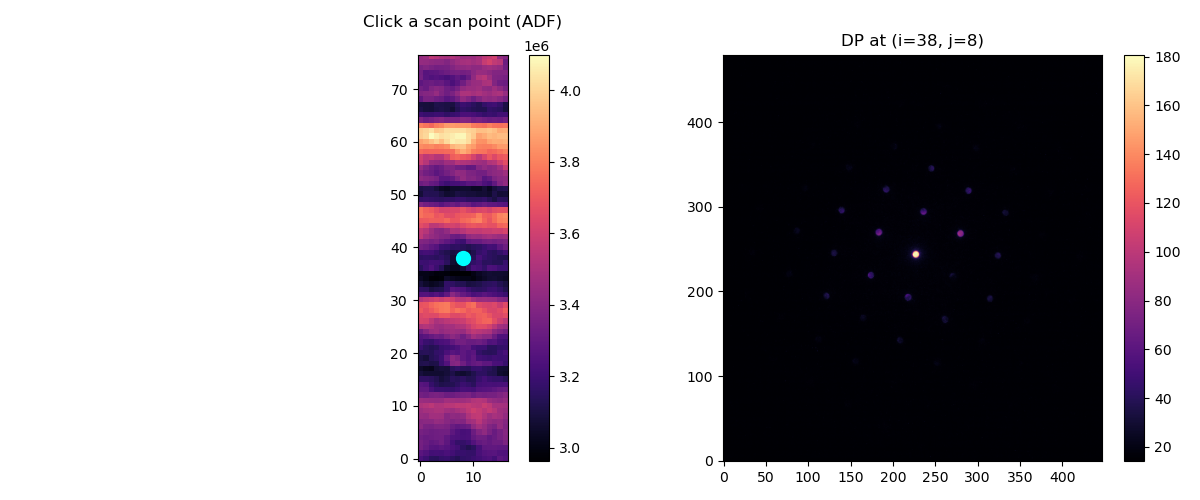

In [40]:
# Alternative interactive display

%matplotlib widget

img = results_sige["virtual_images"]["ADF"]
data4d = data4d_sige

sx, sy, ny, nx = data4d.shape

fig, (ax_img, ax_dp) = plt.subplots(1, 2, figsize=(12, 5))

im0 = ax_img.imshow(img, cmap="magma", origin="lower")
ax_img.set_title("Click a scan point (ADF)", pad = 20)
plt.colorbar(im0, ax=ax_img, fraction=0.046, pad=0.04)

# Initialize DP view
dp0 = np.sqrt(data4d[sx//2, sy//2])
im1 = ax_dp.imshow(dp0, cmap="magma", origin="lower")
ax_dp.set_title(f"DP at (i={sx//2}, j={sy//2})")
plt.colorbar(im1, ax=ax_dp, fraction=0.046, pad=0.04)

marker = ax_img.plot([sy//2], [sx//2], marker="o", markersize=10, color="cyan", linestyle="")[0]

def onclick(event):
    if event.inaxes != ax_img or event.xdata is None or event.ydata is None:
        return

    j = int(round(event.xdata))  # col
    i = int(round(event.ydata))  # row

    if not (0 <= i < sx and 0 <= j < sy):
        return

    marker.set_data([j], [i])

    dp = np.sqrt(data4d[i, j])
    im1.set_data(dp)
    ax_dp.set_title(f"DP at (i={i}, j={j})")

    # Rescale DP contrast a bit each time
    im1.set_clim(vmin=np.min(dp), vmax=np.max(dp))

    fig.canvas.draw_idle()

cid = fig.canvas.mpl_connect("button_press_event", onclick)
plt.tight_layout()
plt.show()

# Task 5. Finalize & Submit

#### See GitHub Repository for finalized assignment, imported figures, and updated README.md.